### LIME for image classification

This is an example of the LIME explainer for image data. This explainer only supports image classification tasks. If using this explainer, please cite the original work: https://github.com/marcotcr/lime.

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import json
import unittest
import torch
from torchvision import models, transforms
from PIL import Image as PilImage
from omnixai.data.image import Image
from omnixai.explainers.vision import LimeImage

We recommend using `Image` to represent a batch of images. `Image` can be constructed from a numpy array or a Pillow image. The following code loads one test image and the class names on ImageNet.

In [3]:
# Load the test image
img = Image(PilImage.open('../data/images/dog_cat.png').convert('RGB'))
# Load the class names
with open('../data/images/imagenet_class_index.json', 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

The model applied here is a Inception model pretrained on ImageNet.

In [4]:
model = models.inception_v3(pretrained=True)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Let's check the predicted labels of the test image.

In [5]:
model.eval()
input_img = transform(img.to_pil()).unsqueeze(dim=0)
probs_top_5 = torch.nn.functional.softmax(model(input_img), dim=1).topk(5)
r = tuple((p, c, idx2label[c]) for p, c in
          zip(probs_top_5[0][0].detach().numpy(), probs_top_5[1][0].detach().numpy()))
print(r)

((0.93592954, 239, 'Bernese_mountain_dog'), (0.038448237, 241, 'EntleBucher'), (0.023756476, 240, 'Appenzeller'), (0.0018181928, 238, 'Greater_Swiss_Mountain_dog'), (9.113302e-06, 214, 'Gordon_setter'))


To initialize `LimeImage`, we need to set the following parameters:

  - `predict_function`: The prediction function corresponding to the machine learning model to explain. For classification, the outputs of the ``predict_function`` are the class probabilities.

  0%|          | 0/1000 [00:00<?, ?it/s]

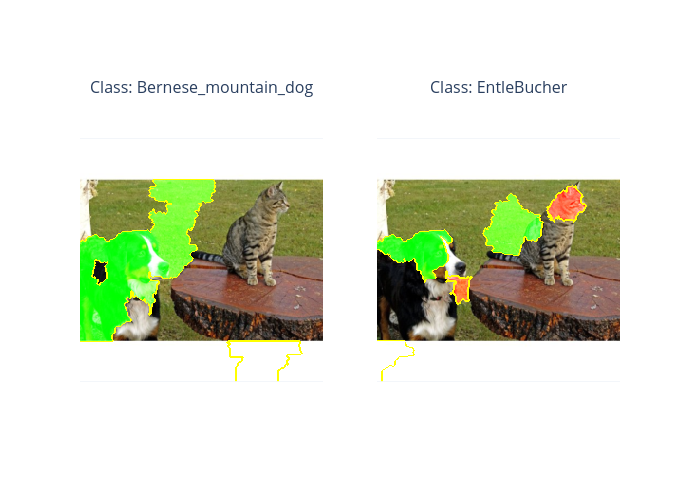

In [7]:
def batch_predict(images):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device)
    batch = torch.stack([transform(img.to_pil()) for img in images])
    batch = batch.to(device)
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

explainer = LimeImage(predict_function=batch_predict)
# Explain the top labels
explanations = explainer.explain(img, hide_color=0, num_samples=1000)
explanations.ipython_plot(index=0, class_names=idx2label)